# CS 450 AI Surf Predictions
In this project, we are using data about beach conditions to predict surf quality. We train a Random Forest Regressor model using its base hyperparameters, evaluate its results, and then use GridSearchCV to tune the hyperparameters of the Random Forest Regressor model, and run it again. The code is split into four sections, Data Formatting, Default Random Forest Regressor, GridSearchCV, Tuned Random Forest Regressor, and Improvements

## Section 1: Data formatting

In [2]:
import pandas as pd

# Load the dataset
file_path = 'waves_statsV1.csv'
data = pd.read_csv(file_path)

# Define secondary swell columns to check
# Seeing if any of these == Nothing, in that case i set to Naan
secondary_swell_cols = [
    "Seconday 1 -> height", "Seconday 1 -> period", "Seconday 1 -> letters", "Seconday 1 -> angle", "Secondary 1 -> Points off",
    "Seconday 2 -> height", "Seconday 2 -> period", "Seconday 2 -> letters", "Seconday 2 -> angle", "Secondary 2 -> Points off",
    "Seconday 3 -> height", "Seconday 3 -> period", "Seconday 3 -> letters", "Seconday 3 -> angle", "Secondary 3 -> Points off",
    "Primary -> Points off",
    "Wind -> Points off"
]

# Iterate through rows and check for missing values of the rows in the list up there
for index, row in data.iterrows():
    for col in secondary_swell_cols:
        if pd.isna(row[col]) or row[col] == '':
            data.at[index, col] = None  # Replace missing or empty values with None

# Display the cleaned dataset
# data

In [ ]:
# Dropping Columns that are not nessesary for predicitng surf quality
#  we need to remove all of the unesseary features, since i picked all beach breaks on the pacific west coast, we are treating
# this as one surf break, no need to include directios relative to the shore line nor location/date/times.

# List of columns to drop
columns_to_drop = [
    "DocumentID", "DatesDocumentID", "timestamp", "name", "County", "Name", "data",
    "Surf Height: Direction",
    "Seconday 1 -> letters",
    "Primary -> letters",
    "Seconday 2 -> letters",
    "Seconday 3 -> letters",
    "Wind Direction (NSEW)"
]

# Drop the columns from the DataFrame
data_swell = data.drop(columns=columns_to_drop)

# shuffling all lines, forecasts are cumlative which means it would be biased if we split the data without shuffling
data_swell = data_swell.sample(frac=1, random_state=42).reset_index(drop=True)

# Display updated dataset
# data_swell

## Section 2: Default Random Forest Regressor

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Convert categorical column to one-hot encoding
data_swell_encoded = pd.get_dummies(data_swell, columns=["Wind Direction (Human Relation)"], drop_first=True)

# Features and target
features = data_swell_encoded.drop(columns=['Star Rating'])
target = data_swell_encoded['Star Rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
default_mae = mean_absolute_error(y_test, predictions)
default_r2 = r2_score(y_test, predictions)

# Output evaluation metrics
print(f"Mean Absolute Error (MAE): {default_mae}")
print(f"R-squared Score: {default_r2}")

# Feature importance (optional)
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("10 most important features:")
print(feature_importances.head(10))

Mean Absolute Error (MAE): 0.10833271118506758
R-squared Score: 0.9591199732559867
10 most important features:
                                      Feature  Importance
3                                  Wave Power    0.767161
22                         Wind -> Points off    0.083602
25      Wind Direction (Human Relation)_glass    0.070053
21                         Primary Wind Speed    0.012145
20                     Wind Direction (Angle)    0.010908
24   Wind Direction (Human Relation)_cross-on    0.009128
23  Wind Direction (Human Relation)_cross-off    0.004770
13                       Seconday 2 -> period    0.004321
14                        Seconday 2 -> angle    0.003483
10                        Seconday 1 -> angle    0.002993


## Section 3: GridSearchCV

In [5]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize grid search
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3, 
                           scoring='neg_mean_absolute_error', 
                           verbose=1, 
                           n_jobs=-1)

# Perform the search
grid_search.fit(X_train, y_train)

# Display the best parameters and their score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MAE: {-grid_search.best_score_}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MAE: 0.11380886932102396


## Section 4: Tuned Random Forest Regressor

In [6]:
# Update the model with best parameters
tuned_model = grid_search.best_estimator_
tuned_model.fit(X_train, y_train)

# Predict on the test set
predictions = tuned_model.predict(X_test)

# Evaluate the model
tuned_mae = mean_absolute_error(y_test, predictions)
tuned_r2 = r2_score(y_test, predictions)

# Output evaluation metrics
print(f"Mean Absolute Error (MAE): {tuned_mae}")
print(f"R-squared Score: {tuned_r2}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tuned_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("10 most important features:")
print(feature_importances.head(10))

Mean Absolute Error (MAE): 0.10801981854811511
R-squared Score: 0.9595541760983707
10 most important features:
                                      Feature  Importance
3                                  Wave Power    0.768122
22                         Wind -> Points off    0.082723
25      Wind Direction (Human Relation)_glass    0.069589
21                         Primary Wind Speed    0.012213
20                     Wind Direction (Angle)    0.010926
24   Wind Direction (Human Relation)_cross-on    0.009432
23  Wind Direction (Human Relation)_cross-off    0.004760
13                       Seconday 2 -> period    0.004257
14                        Seconday 2 -> angle    0.003504
10                        Seconday 1 -> angle    0.002852


## Section 5: Improvements

In [7]:
# Default model
print("Default Model Performance:")
print(f"MAE: {default_mae:.4f}")
print(f"R²: {default_r2:.4f}")

# Tuned model
print("\nTuned Model Performance:")
print(f"MAE: {tuned_mae:.4f}")
print(f"R²: {tuned_r2:.4f}")

# Calculate improvements
mae_improvement = default_mae - tuned_mae
r2_improvement = tuned_r2 - default_r2

# Display improvements
print("\nPerformance Improvement After Hyperparameter Tuning:")
print(f"MAE Improvement: {mae_improvement:.4f}")
print(f"R² Improvement: {r2_improvement:.4f}")

Default Model Performance:
MAE: 0.1083
R²: 0.9591

Tuned Model Performance:
MAE: 0.1080
R²: 0.9596

Performance Improvement After Hyperparameter Tuning:
MAE Improvement: 0.0003
R² Improvement: 0.0004


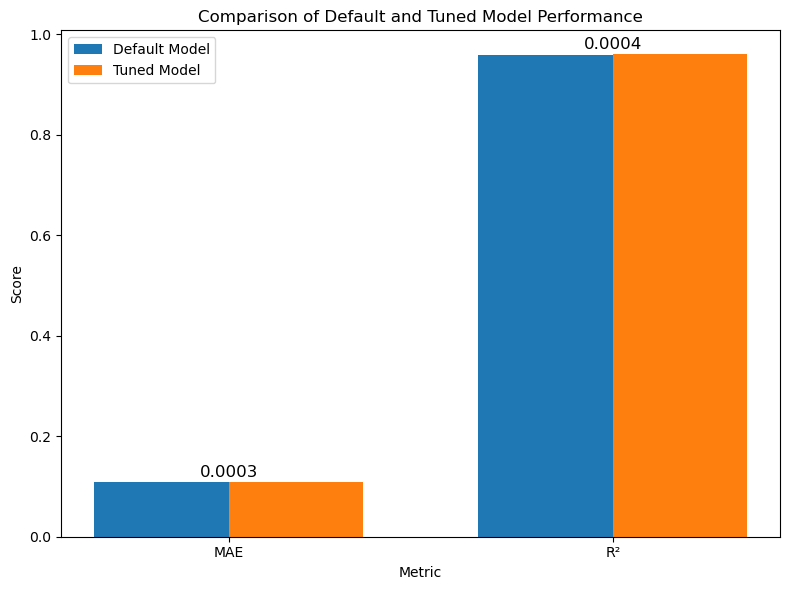

In [ ]:
import matplotlib.pyplot as plt

# Define the values for the original and tuned models
metrics = ['MAE', 'R²']
default_performance = [default_mae, default_r2]
tuned_performance = [tuned_mae, tuned_r2]
improvements = [default_mae - tuned_mae, tuned_r2 - default_r2]

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Bar positions for default and tuned model
bar_width = 0.35
index = range(len(metrics))

# Plot bars for default and tuned models
bar1 = ax.bar(index, default_performance, bar_width, label='Default Model')
bar2 = ax.bar([i + bar_width for i in index], tuned_performance, bar_width, label='Tuned Model')

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Default and Tuned Model Performance')
ax.set_xticks([i + bar_width / 2 for i in index])  # Positioning the x-axis labels between bars
ax.set_xticklabels(metrics)
ax.legend()

# Display the improvements
for i, v in enumerate(improvements):
    ax.text(i + bar_width / 2, max(default_performance[i], tuned_performance[i]) + 0.005,
            f'{v:.4f}', ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()